## 【検証】Driverless AIのスコアリング機能を目的関数とした、GPyOptによるベイズ最適化
- あるDriverless AIの学習済みモデルにおいて、ターゲット変数yを最小化/最大化する、特徴量Xを計算したい

[2021/6/20] App実装検証用に修正

In [1]:
from GPyOpt.methods import BayesianOptimization
import os
import driverlessai
import pandas as pd
import numpy as np

### 学習データ
データはDriverless AIへアップロード済みだが、データ理解のため

In [2]:
data_name = os.path.join(os.environ['HOME'], 'Documents/Sample_Data/Boston_Housing/BostonHousing.csv')
df_tmp = pd.read_csv(data_name)
print(df_tmp.shape)
df_tmp.head()

(506, 14)


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


[The Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html)

In [3]:
df_tmp.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


ターゲット変数：MEDV  
特徴量：MEDV以外の13変数

### Driverless AIへの接続

In [4]:
import json
with open('../idpass.json') as f:
    idpass = json.load(f)

In [5]:
# Driverless AIサーバーへの接続
dai = driverlessai.Client(address='http://54.209.194.59:12345', username=idpass['id'], password=idpass['pass1921_2'])
dai

<class 'driverlessai._core.Client'> http://54.209.194.59:12345

In [6]:
# 接続先Driverless AIのDatasets
dai.datasets.list()

    | Type    | Key                                  | Name
----+---------+--------------------------------------+---------------------------------
  0 | Dataset | da200da0-d16b-11eb-bded-0242ac110002 | tmp_pred.csv
  1 | Dataset | a8a489e2-d169-11eb-bded-0242ac110002 | tmp_pred.csv
  2 | Dataset | 783e4bf8-d169-11eb-bded-0242ac110002 | tmp_pred.csv
  3 | Dataset | 63ed5e8c-d169-11eb-bded-0242ac110002 | tmp_pred.csv
  4 | Dataset | 1ff439bc-d169-11eb-bded-0242ac110002 | tmp_pred.csv
  5 | Dataset | 16d59c36-d169-11eb-bded-0242ac110002 | tmp_pred.csv
  6 | Dataset | 7020a422-cefb-11eb-88a5-0242ac110002 | BostonHousing_Cate.csv
  7 | Dataset | d01699e0-ce51-11eb-869d-0242ac110002 | walmart_ts_6_fcst_grp_test.csv
  8 | Dataset | cda6e46c-ce51-11eb-869d-0242ac110002 | walmart_ts_6_fcst_grp_train.csv
  9 | Dataset | c94324ee-ce51-11eb-869d-0242ac110002 | AirPassengers.csv
 10 | Dataset | 3b5a67c8-c8b1-11eb-a4d7-0242ac110002 | Boston_Test
 11 | Dataset | 3b5a3fe6-c8b1-11eb-a4d7-0242ac110002 

In [7]:
# 接続先Driverless AIのExperiments
dai.experiments.list()

    | Type       | Key                                  | Name
----+------------+--------------------------------------+-----------------
  0 | Experiment | 11985ddc-cf00-11eb-88a5-0242ac110002 | 1.fecuficu
  1 | Experiment | 838303d4-cefb-11eb-88a5-0242ac110002 | fecuficu
  2 | Experiment | 21f08096-ce52-11eb-869d-0242ac110002 | wallmart_1
  3 | Experiment | 42f05b12-c9b7-11eb-9503-0242ac110002 | boston
  4 | Experiment | 4e4b1c9c-c8b1-11eb-a4d7-0242ac110002 | fapofuvi
  5 | Experiment | 6cae13a6-c7e9-11eb-8705-0242ac110002 | titanic_default

#### Experiment情報の取得

In [8]:
# 利用するExperimentの取得
# 目的関数となる予測モデル

experiment = dai.experiments.get(key='42f05b12-c9b7-11eb-9503-0242ac110002')
type(experiment)

driverlessai._experiments.Experiment

In [9]:
# Experiment作成で利用したデータ
experiment.datasets

{'train_dataset': <class 'Dataset'> 20951d84-c8b1-11eb-a4d7-0242ac110002 BostonHousing.csv,
 'validation_dataset': None,
 'test_dataset': None}

In [10]:
# 学習データのKey
experiment.datasets['train_dataset'].key

'20951d84-c8b1-11eb-a4d7-0242ac110002'

In [11]:
# Experimentのターゲットカラム
target_col = experiment.settings['target_column']
target_col

'MEDV'

In [12]:
# droped columns
try:
    drop_cols = experiment.settings['drop_columns']     # dropカラムがリストで返る
except KeyError:
    drop_cols = []     # dropしたカラムがない場合

drop_cols

[]

In [13]:
# Experiment結果のサマリ
experiment.summary()

Status: Complete
Experiment: nutepuli (42f05b12-c9b7-11eb-9503-0242ac110002)
  Version: 1.9.2.1, 2021-06-10 06:52
  Settings: 7/2/8, seed=718318666, GPUs disabled
  Train data: BostonHousing.csv (506, 14)
  Validation data: N/A
  Test data: N/A
  Target column: MEDV (regression)
System specs: Docker/Linux, 31 GB, 8 CPU cores, 0/0 GPU
  Max memory usage: 0.758 GB, 0 GB GPU
Recipe: AutoDL (38 iterations, 8 individuals)
  Validation scheme: random, 6 internal holdouts (3-fold CV)
  Feature engineering: 311 features scored (17 selected)
Timing: MOJO latency: 0.21310 millis (2.3MB)
  Data preparation: 4.59 secs
  Shift/Leakage detection: 0.68 secs
  Model and feature tuning: 273.23 secs (151 of 210 models trained)
  Feature evolution: 143.30 secs (222 of 528 models trained)
  Final pipeline training: 10.12 secs (6 models trained)
  Python / MOJO scorer building: 38.22 secs / 20.79 secs
Validation score: RMSE = 9.188011 (constant preds of 22.53)
Validation score: RMSE = 3.675483 +/- 0.239089

#### 学習データ情報の取得

In [14]:
dataset = dai.datasets.get(key=experiment.datasets['train_dataset'].key)
dataset

<class 'Dataset'> 20951d84-c8b1-11eb-a4d7-0242ac110002 BostonHousing.csv

In [15]:
# 学習データのカラム
data_cols = dataset.columns
data_cols

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT',
 'MEDV']

In [16]:
# Experiment作成に用いられた学習データのカラム

col_no_show = drop_cols.copy()
col_no_show.append(target_col)    # 学習データから除くカラム（ターゲット変数とdropped columns）

col_show = []
for col in data_cols:
    if col in col_no_show: 
        continue
    col_show.append(col)

col_show

['CRIM',
 'ZN',
 'INDUS',
 'CHAS',
 'NOX',
 'RM',
 'AGE',
 'DIS',
 'RAD',
 'TAX',
 'PTRATIO',
 'B',
 'LSTAT']

In [17]:
# Experiment作成に用いられた学習データの特徴量の最小値・最大値

min_list = []
max_list = []
for col in col_show:
    min_list.append(dataset.column_summaries()[col].min)
    max_list.append(dataset.column_summaries()[col].max)

df_domain = pd.DataFrame({'col':col_show, 'min':min_list, 'max':max_list})
df_domain

,col,min,max
0,CRIM,0.00632,88.9762
1,ZN,0.00000,100.0000
2,INDUS,0.46000,27.7400
3,CHAS,0.00000,1.0000
4,NOX,0.38500,0.8710
5,RM,3.56100,8.7800
6,AGE,2.90000,100.0000
7,DIS,1.12960,12.1265
8,RAD,1.00000,24.0000
9,TAX,187.00000,711.0000


In [18]:
# 特徴量のデータタイプ指定（'continuous', 'discrete'）
# ToDo: 絡むによる指定

df_domain['type'] = 'continuous'
df_domain

,col,min,max,type
0,CRIM,0.00632,88.9762,continuous
1,ZN,0.00000,100.0000,continuous
2,INDUS,0.46000,27.7400,continuous
3,CHAS,0.00000,1.0000,continuous
4,NOX,0.38500,0.8710,continuous
5,RM,3.56100,8.7800,continuous
6,AGE,2.90000,100.0000,continuous
7,DIS,1.12960,12.1265,continuous
8,RAD,1.00000,24.0000,continuous
9,TAX,187.00000,711.0000,continuous


### GPyOptによるベイズ最適化

#### GPyOpt.methods.bayesian_optimization.BayesianOptimization
- Main class to initialize a Bayesian Optimization method
- https://gpyopt.readthedocs.io/en/latest/GPyOpt.methods.html#GPyOpt.methods.bayesian_optimization.BayesianOptimization

In [19]:
# 目的関数（スコアリング用関数）
# daimodel(x)が最小、もしくは最大となるxを計算したい

def daimodel(x):
    ''' col_show（学習に使われたカラム名のリスト）が必要
    '''
    # スコアリングデータの作成
    df = pd.DataFrame(np.array([x[:,i] for i in range(len(col_show))]).reshape(1, len(col_show)), columns=col_show)
    #print(df)
    df.to_csv('tmp_pred.csv', index=False)
    # スコアリングデータをDAIへアップロード
    data_to_predict = dai.datasets.create(data='./tmp_pred.csv', data_source='upload', name='tmp_pred.csv', force=True)
    # 予測
    dai_predictions = experiment.predict(dataset=data_to_predict, include_columns=data_to_predict.columns)
    # スコアリングデータの削除
    data_to_predict.delete()
    # クライアント実行ディレクトリ上にダウンロード
    dai_predictions.download(dst_dir='', dst_file='tmp_res.csv', overwrite=True)    # tmp_res.csvとしてダウンロード
    df_res = pd.read_csv('tmp_res.csv')
    print('---------- Done ----------')
    # 予測結果（ターゲット変数のみ）をnp.arrayで返す
    return np.array(df_res[experiment.settings['target_column']])

In [22]:
# 各変数の情報。domeinは入力の定義域（学習データの[最小値,最大値]と設定）
bounds = [{'name':row['col'], 'type':row['type'], 'domain':(row['min'],row['max'])} for _, row in df_domain.iterrows()]
bounds

[{'name': 'CRIM', 'type': 'continuous', 'domain': (0.00632, 88.9762)},
 {'name': 'ZN', 'type': 'continuous', 'domain': (0.0, 100.0)},
 {'name': 'INDUS', 'type': 'continuous', 'domain': (0.46, 27.74)},
 {'name': 'CHAS', 'type': 'continuous', 'domain': (0.0, 1.0)},
 {'name': 'NOX', 'type': 'continuous', 'domain': (0.385, 0.871)},
 {'name': 'RM', 'type': 'continuous', 'domain': (3.561, 8.78)},
 {'name': 'AGE', 'type': 'continuous', 'domain': (2.9, 100.0)},
 {'name': 'DIS', 'type': 'continuous', 'domain': (1.1296, 12.1265)},
 {'name': 'RAD', 'type': 'continuous', 'domain': (1.0, 24.0)},
 {'name': 'TAX', 'type': 'continuous', 'domain': (187.0, 711.0)},
 {'name': 'PTRATIO', 'type': 'continuous', 'domain': (12.6, 22.0)},
 {'name': 'B', 'type': 'continuous', 'domain': (0.32, 396.9)},
 {'name': 'LSTAT', 'type': 'continuous', 'domain': (1.73, 37.97)}]

In [23]:
# ベイズ最適化関数の定義と最適化の実施
myBopt = BayesianOptimization(f=daimodel, domain=bounds, maximize=True)  # maximize=True：最大化問題（-fを最小化）
myBopt.run_optimization(max_iter=10)

Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset tmp_pred.csv (78a8951e-d16c-11eb-bded-0242ac110002) deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset tmp_pred.csv (7cc02b80-d16c-11eb-bded-0242ac110002) deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset tmp_pred.csv (80d6e6dc-d16c-11eb-bded-0242ac110002) deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset tmp_pred.csv (84ed800a-d16c-11eb-bded-0242ac110002) deleted.
Downloaded 'tmp_res.csv'
---------- Done ----------
Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset tmp_pred.csv (890f6b4e-d16c-

In [24]:
# 結果（xの最適解）
myBopt.x_opt

array([5.06235325e+01, 1.36479601e+01, 8.66215569e+00, 6.35748896e-01,
       6.49800649e-01, 8.05514694e+00, 2.86518170e+01, 8.49271905e+00,
       8.35491810e+00, 6.40812184e+02, 1.84972209e+01, 3.23978975e+02,
       1.84529328e+00])

In [37]:
pd.DataFrame(myBopt.x_opt.reshape(1,len(col_show)), columns=col_show)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,50.623532,13.64796,8.662156,0.635749,0.649801,8.055147,28.651817,8.492719,8.354918,640.812184,18.497221,323.978975,1.845293


In [25]:
# 最適解xの時の、目的関数の値
# 最大化問題として解いたので、-1*myBopt.fx_optが達成した値
myBopt.fx_opt

-43.589596

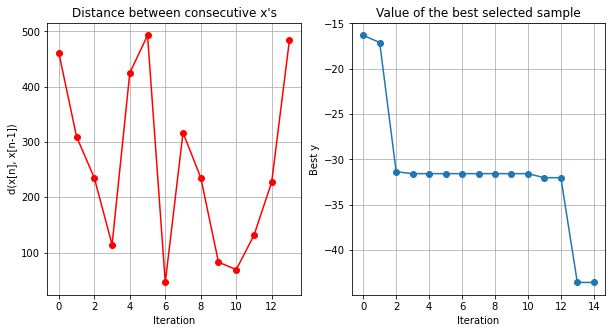

In [26]:
# 最適化履歴
myBopt.plot_convergence()

In [27]:
# 途中計算されたインプットとアウトプット
#print(myBopt.X)
print(myBopt.X.shape)
#print(myBopt.Y)
print(myBopt.Y.shape)

(15, 13)
(15, 1)


In [28]:
#myBopt.model.model 

#### xの最適解(myBopt.x_opt)を入力として、スコアリングを実施してみる

In [30]:
df_scoring = pd.DataFrame({'CRIM': [myBopt.x_opt[0]],
                           'ZN': [myBopt.x_opt[1]],
                           'INDUS': [myBopt.x_opt[2]],
                           'CHAS': [myBopt.x_opt[3]],
                           'NOX': [myBopt.x_opt[4]],
                           'RM': [myBopt.x_opt[5]],
                           'AGE': [myBopt.x_opt[6]],
                           'DIS': [myBopt.x_opt[7]],
                           'RAD': [myBopt.x_opt[8]],
                           'TAX': [myBopt.x_opt[9]],
                           'PTRATIO': [myBopt.x_opt[10]],
                           'B': [myBopt.x_opt[11]],
                           'LSTAT': [myBopt.x_opt[12]]}) 
df_scoring

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,50.623532,13.64796,8.662156,0.635749,0.649801,8.055147,28.651817,8.492719,8.354918,640.812184,18.497221,323.978975,1.845293


In [31]:
# ローカル保存
df_scoring.to_csv('scoring_test.csv', index=False)
# DAIへアップロード
data_to_predict = dai.datasets.create(data='./scoring_test.csv', data_source='upload', name='scoring_test.csv', force=True)
# 予測
dai_predictions = experiment.predict(dataset=data_to_predict, include_columns=data_to_predict.columns)
# スコアリングデータの削除
data_to_predict.delete()
# クライアント実行ディレクトリ上にダウンロード
dai_predictions.download(dst_dir='', dst_file='res.csv', overwrite=True)    # res.csvとしてダウンロード
df_res = pd.read_csv('res.csv')
df_res

Complete 100.00% - [4/4] Computed stats for column LSTAT
Complete
Driverless AI Server reported dataset scoring_test.csv (f8f6f9ea-d16c-11eb-bded-0242ac110002) deleted.
Downloaded 'res.csv'


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV,MEDV.lower,MEDV.upper
0,50.623532,13.64796,8.662156,0.635749,0.649801,8.055147,28.651817,8.492719,8.354918,640.812184,18.497221,323.978975,1.845293,43.589596,38.768272,47.68873


In [32]:
# myBopt.x_optを入力とした時の、予測結果
df_res['MEDV']

0    43.589596
Name: MEDV, dtype: float64